# Import the libraries

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score, roc_curve

# Import training Data

In [108]:
df=pd.read_csv('train.csv')

In [110]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [114]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Check for data imbalance

In [117]:
df.groupby('Survived')['Survived'].value_counts()
# Slightly imbalanced

Survived
0    549
1    342
Name: count, dtype: int64

# Numeric features correlation

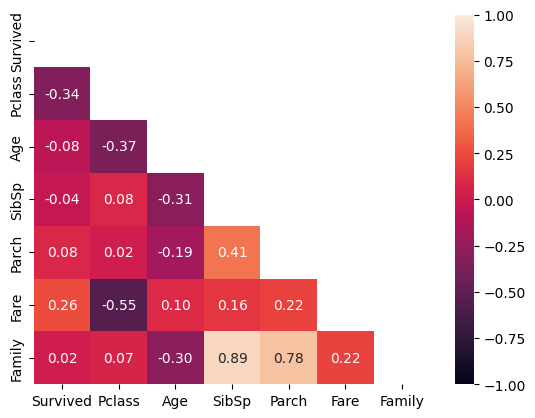

In [120]:
df_corr_features=df.drop('PassengerId',axis=1)
df_corr_features['Family']=df["SibSp"] + df["Parch"] + 1 # feature engineering
df_corr=df_corr_features.corr(numeric_only=True)
sns.heatmap(df_corr,mask=np.triu(df_corr),annot=True,fmt='0.2f',vmin=-1,vmax=1)
plt.show()
# Pclass is correlated with Fare

### Function for extracting the title from the passenger's name

In [122]:
def title(data:pd.DataFrame)->pd.Series:
    data['Title']=data['Name'].str.split(pat=".",expand=True)[0].str.split(pat=',',expand=True)[1].apply(lambda x:x.strip()).replace(
                        {'Col':'Military','Capt':'Military','Major':'Military',
                          'Mme':'Miss','Mlle':'Mrs',
                          'the Countess':'Nobility','Don':'Nobility',
                         'Jonkheer':'Nobility','Sir':'Nobility','Lady':'Nobility','Dona':'Nobility'})
    return data["Title"]

### Setting up the features and the target

In [126]:
df['Title']=title(df)
X=df.drop(['Name','Cabin','PassengerId','Ticket','Survived'],axis=1) #drop Cabin because of lack in data
y=df['Survived']

# Import testing Data


In [129]:
df_test=pd.read_csv('test.csv')
df_test['Title']=title(df_test)
X_test=df_test.drop(['Name','Cabin','PassengerId','Ticket'],axis=1) #drop Cabin 'not a feature in training'
y_test=pd.read_csv('gender_submission.csv').drop('PassengerId',axis=1)

# Exploratory data analysis

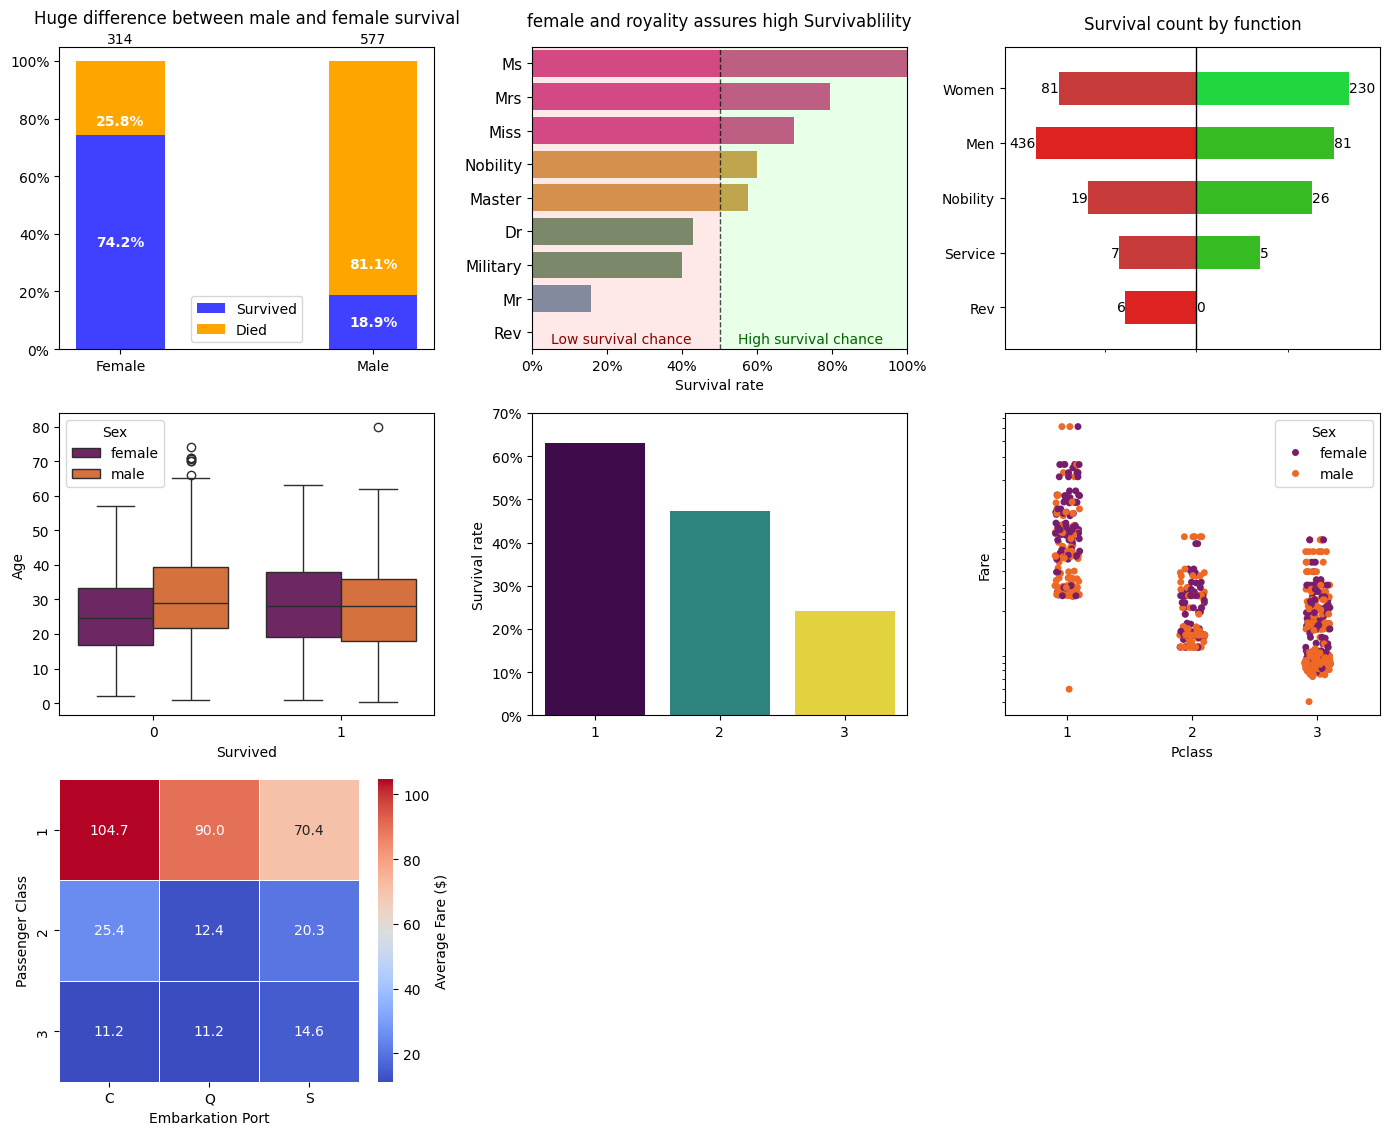

In [132]:
plt.figure(figsize=(14,11))

plt.subplot(3, 3, 1) #Survival based on Sex

# Calculate mean survival/died by sex
sex_counts = df['Sex'].value_counts().to_dict()
mean_sex = df.groupby('Sex')['Survived'].agg(mean_survived='mean').reset_index()
mean_sex['mean_died'] = 1 - mean_sex['mean_survived']

colors = {'Survived': 'blue', 'Died': 'orange'}
sex_labels = ['Female', 'Male']

# Plot stacked bars
for i, sex in enumerate(['female', 'male']):
    subset = mean_sex[mean_sex['Sex'] == sex].iloc[0]
    count = sex_counts[sex]
    
    # Plot bars
    survived_bar = plt.bar(i, subset['mean_survived'], width=0.35, color=colors['Survived'],
                           label='Survived' if i == 0 else "",alpha=0.75)
    died_bar = plt.bar(i, subset['mean_died'],width=0.35,color=colors['Died'], 
                       bottom=subset['mean_survived'],label='Died' if i == 0 else "")
    
    # Add percentage text in the green (survived) section
    plt.text(i, subset['mean_survived']/2, f"{subset['mean_survived']:.1%}", 
             ha='center', va='center', color='white', fontweight='bold')
    plt.text(i, subset['mean_survived'] + subset['mean_died']*0.1,  # 10% into red section
            f"{subset['mean_died']:.1%}", 
            ha='center', va='bottom', color='white', fontweight='bold')
    plt.text(i, 1.05,f"{count}", ha='center', va='bottom', color='black', fontsize=10)

# Customize plot
plt.xticks([0, 1], sex_labels)
plt.ylabel('')
plt.yticks(np.arange(0,1.2,0.2),[f'{i:.0f}%'for i in np.arange(0,1.2,0.2)*100])
plt.title("Huge difference between male and female survival",y=1.05)
plt.legend()

plt.subplot(3, 3, 2) # Survival based on Title

# calculate mean of survival after grouping by title
groupby_Title = pd.DataFrame(df.groupby('Title', as_index=False)['Survived'].mean().sort_values(by='Survived',ascending=False))

# set up the palette
custom_palette = ['#db006e'] * 3 + 2*['#de8407'] + ['#3A7D44'] *2 +['#427AA1']*2

# plot bars
sns.barplot(groupby_Title,x='Survived',y='Title',palette=custom_palette,hue='Title',legend=False)
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=1, alpha=0.7)

# coloring >50% with green and <50% with red
plt.axvspan(0, 0.5, facecolor='#ffb6b6', alpha=0.3)
plt.axvspan(0.5, 1.0, facecolor='#b6ffb6', alpha=0.3)

# nameing each region
plt.text(0.05, len(groupby_Title)-0.8, 'Low survival chance', color='darkred', va='center')
plt.text(0.55, len(groupby_Title)-0.8, 'High survival chance', color='darkgreen', va='center')

# Customize plot
plt.yticks(fontsize=11)
plt.ylabel('')
plt.xticks(np.arange(0,1.01,0.2),[f'{i:.0f}%'for i in np.arange(0,1.2,0.2)*100])
plt.xlim(0,1)
plt.xlabel('Survival rate')
plt.title("female and royality assures high Survivablility",y=1.04)

plt.subplot(3, 3, 3) # Survival based on function
# grouping titles in a new columns representing the function of each passenger 
df['Function']=df['Title'].map({'Miss':'Women','Mrs':"Women",'Ms':'Women',
         'Nobility':'Nobility','Master':'Nobility','Military':'Service',
        'Dr':'Service','Mr':'Men','Rev':'Rev'})

# extracting the passangers based on their function,died and survived count
groupby_Function = df.groupby('Function')['Survived'].value_counts().unstack().fillna(0).astype(int).rename(
    columns={0: 'Died', 1: 'Survived'}).sort_values(by='Survived',ascending=False)

df=df.drop('Function',axis=1) # drop the function column after grouping "corr between title|function is probable"

survived=groupby_Function["Survived"].replace(0, 1) # avoid infy in logarithmic scaling
died=groupby_Function['Died']
function=groupby_Function.index

# set up the palette
survival_palette = ['#02f52b'] + ['#24d408'] * (len(function) - 1)
died_palette=['#de2323']+['#fc0303']+2*['#de2323']+['#fc0303']

sns.barplot(x=np.log10(survived), y=function, palette=survival_palette
, width=0.6, label='Survived',hue=function,legend=False)
sns.barplot(x=-np.log10(died), y=function, palette=died_palette, width=0.6, label='Died'
              ,hue=function,legend=False)

# Custom logarithmic scaling
plt.xscale('symlog', linthresh=1, linscale=0.5)
plt.axvline(0, color='black', linewidth=1)
plt.xticks([])

for i, (s, d) in enumerate(zip(survived[:-1], died[:-1])):
    plt.text(np.log10(s), i, f'{s}', ha='left', va='center', color='black')
    plt.text(-np.log10(d), i, f'{d}', ha='right', va='center', color='black')

# handle infy seperately 
plt.text(0, 4, f'{0}', ha='left', va='center', color='black')
plt.text(-np.log10(6), 4, f'{6}', ha='right', va='center', color='black')

# Styling
plt.title('Survival count by function',y=1.03)
plt.ylabel('')
plt.xlabel('')
plt.margins(x=0.1, y=0.1)

plt.subplot(3, 3, 4) # Age distribution among male and female in both cases of survival 
sns.boxplot(data=df, x="Survived", y="Age", hue="Sex",palette="inferno",hue_order=["female", "male"])

plt.subplot(3, 3, 5) # Effect of Class on chances of survival

# Groupying by Class and mean of survival for each
groupby_Pclass=df.groupby(["Pclass"])["Survived"].mean()
sns.barplot(x=range(1,4),y=groupby_Pclass,palette="viridis",color="green",hue=range(1,4),legend=False)
# Customization
plt.yticks(np.arange(0,0.8,0.1),[f'{i:.0f}%'for i in np.arange(0,0.8,0.1)*100])
plt.ylabel("Survival rate")
plt.tight_layout()

plt.subplot(3, 3, 6) # Relationship between Fare and Pclass "noticed in numeric features correlation"
sns.stripplot(df,x='Pclass',y='Fare',hue='Sex',palette="inferno",hue_order=["female", "male"])
plt.yscale('log') #logarithmic scale
plt.yticks([])
# inverse correlation Fare|Pclass is visible
# male are concentrated in Pclass 3 which has the least survival rate "from graph 6"

plt.subplot(3, 3, 7)
Embarked_Pclass_Fare = df.groupby(['Pclass','Embarked'])["Fare"].mean().unstack().round(1)
sns.heatmap(Embarked_Pclass_Fare, annot=True, fmt='.1f',cmap="coolwarm",linewidths=0.5,cbar_kws={'label': 'Average Fare ($)'})
plt.xlabel("Embarkation Port")
plt.ylabel("Passenger Class")

plt.show()

In [133]:
# Comments on the graphs above
# (graph 1) Male are more prone to die (chivalrous is a possible explaination)
# (graph 2) Hierarchy of survival Women> royalty> Service> Men to explain (1 graph) , 0% of Rev survival
# (graph 3) Investigation of 0% Rev survival and expantion on (graph 3)
# (graph 4) No influence of Age on survival
# (graph 5) class 3 caused most of the deaths 
# (graph 6) Men are distributed in 3 class more (falsified the hypothesis concluded from (graph 1)
# (graph 7) class 3 seats are the cheapest (trade-off between cost and security)

In [134]:
# Conclusion:
#You get what you pay for

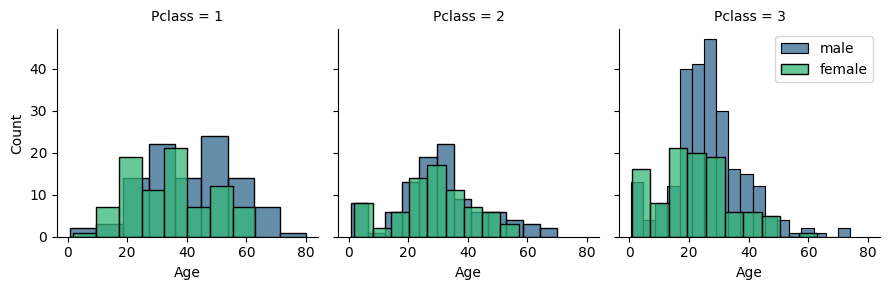

In [135]:
g=sns.FacetGrid(df,col='Pclass',hue='Sex',palette='viridis').map(sns.histplot,'Age')
plt.legend()
plt.show()
# No effect of age accross all classes and specially the third class just compacted by men

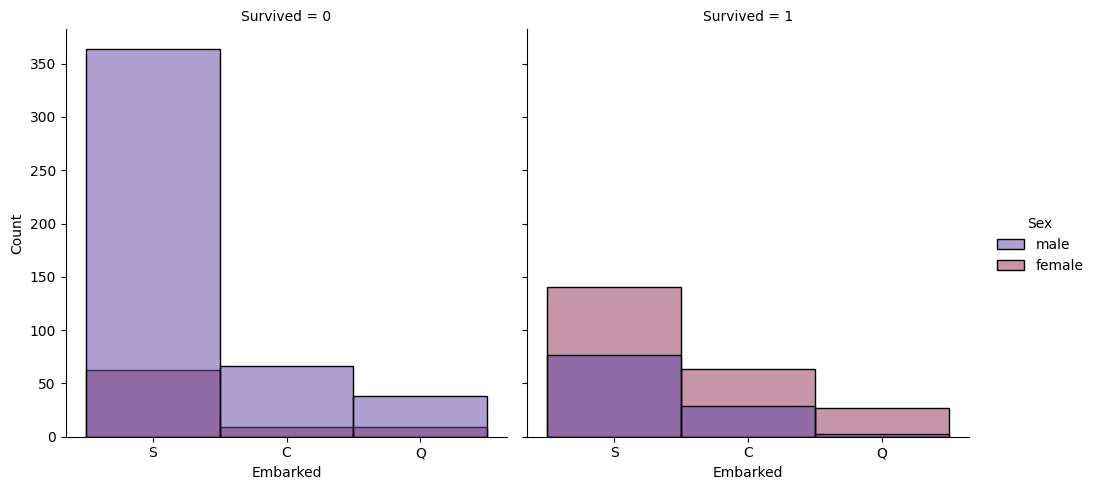

In [139]:
sns.displot(df,x='Embarked',col='Survived',hue='Sex',palette='twilight')
plt.show()

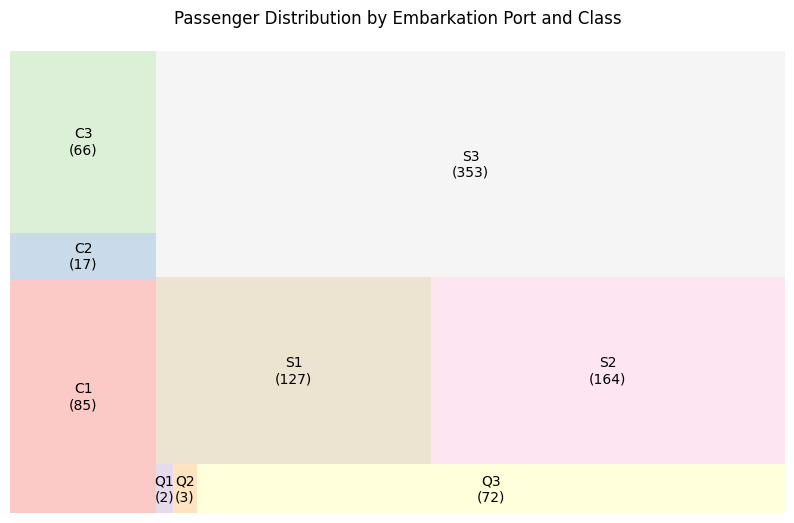

In [140]:
Embarked_Pclass = df.groupby(['Embarked', 'Pclass']).size().unstack()

sizes = []
labels = []
for embarked in Embarked_Pclass.index:
    for pclass in Embarked_Pclass.columns:
        count = Embarked_Pclass.loc[embarked, pclass]
        sizes.append(count)
        labels.append(f"{embarked}{pclass}\n({count})")

plt.figure(figsize=(10, 6))
squarify.plot(sizes=sizes, label=labels, color=plt.cm.Pastel1(range(len(sizes))),alpha=0.7,text_kwargs={'fontsize':10})

plt.title('Passenger Distribution by Embarkation Port and Class', pad=20)
plt.axis('off')

plt.show()

# Preprocessing

In [144]:
ct=ColumnTransformer(transformers=[("Embarked",Pipeline([("Simple Imputer",SimpleImputer(strategy="most_frequent")),
                                                          ("Ohe",OneHotEncoder(sparse_output=False))]),["Embarked"]),
                                                          ("Age",KNNImputer(),["Age"]),
                                                          ("Sex",OneHotEncoder(sparse_output=False),["Sex"]),
                                                          ("Fare",SimpleImputer(strategy="mean"),["Fare"]),
                                                          ("Title",OneHotEncoder(sparse_output=False),["Title"])],
                     remainder="passthrough",verbose_feature_names_out=False).set_output(transform="pandas")

In [147]:
X=ct.fit_transform(X)
X_test=ct.transform(X_test)

# Hyper paramater tuning/Roc curve

In [191]:
models = {
    "Logistic Regression": {
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("LogisticRegression", LogisticRegression(solver='liblinear'))
        ]),
        "params": {
            "LogisticRegression__C": [0.01, 0.1, 1, 10]
        }
    },
    "SVC": {
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("SVC", SVC(probability=True, kernel="linear"))
        ]),
        "params": {
            "SVC__C": [0.1, 1, 10]
        }
    },
    "BernoulliNB": {
        "pipeline": BernoulliNB(),
        "params": {
            "alpha": [0.1, 0.5, 1.0, 5.0, 10.0]
        }
    },
    "Random Forest": {
        "pipeline": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
        }
    },
    "XGBoost": {
        "pipeline": XGBClassifier(eval_metric='logloss'),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5, 7]
        }
    },
    "AdaBoost": {
        "pipeline": AdaBoostClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
        }
    },
    "LightGBM": {
        "pipeline": LGBMClassifier(verbose=-1), # verbose=-1 silences warnings during grid search
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1],
            "num_leaves": [20, 31, 40] # Key LGBM parameter
        }
    }
}

In [172]:
models_grid={}
for name,config in models.items():
    grid = GridSearchCV(config["pipeline"], config["params"], scoring="roc_auc", cv=5)
    grid.fit(X, y)
    print(grid.best_params_)
    models_grid[name]=grid

{'LogisticRegression__C': 0.1}
{'SVC__C': 10}
{'alpha': 0.1}
{'max_depth': 10, 'n_estimators': 200}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
{'learning_rate': 0.1, 'n_estimators': 200}
{'learning_rate': 0.01, 'n_estimators': 100, 'num_leaves': 31}


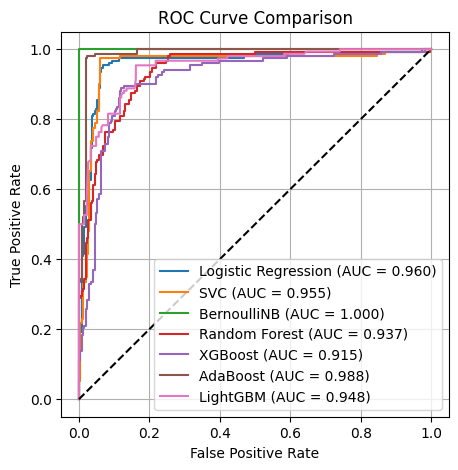

In [173]:
plt.figure(figsize=(5,5))
for name in models_grid:
    y_proba = models_grid[name].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')
    plt.legend()
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()

## Model selection

In [184]:
BerNB=models_grid["BernoulliNB"]
BerNB.fit(X,y)
y_pred=BerNB.predict(X_test)
report=classification_report(y_test,y_pred)
cross_validation_score=np.average(cross_val_score(BerNB,X,y.values.ravel(),n_jobs=-1,cv=5))

### Evaluation

In [187]:
print(report)
print(cross_validation_score)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       266
           1       0.96      1.00      0.98       152

    accuracy                           0.99       418
   macro avg       0.98      0.99      0.98       418
weighted avg       0.99      0.99      0.99       418

0.804032870173852


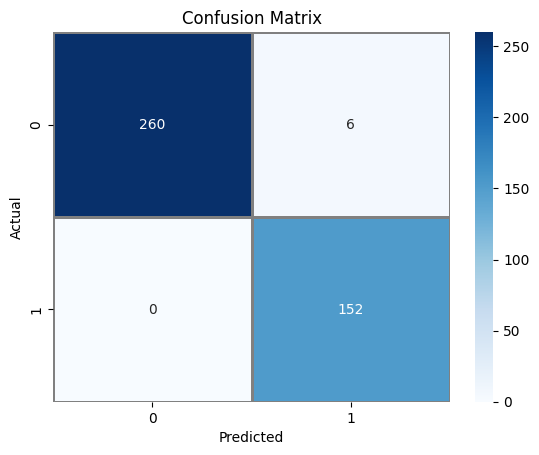

In [189]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True, fmt='d', cmap='Blues',linewidths=1,linecolor='grey')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()